In [30]:
import data_reader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'

dr = data_reader.DataReader()
choices, dynamics = dr.read_data(data_path)

In [32]:
def get_indifference_point_staircase(choices, delay):
    if len(choices[~choices.ss_chosen])==0:
        ip = 0
    elif len(choices[choices.ss_chosen])==0:
        ip = 1
    else:
        ip = (choices[choices.ss_chosen].amount_ratio.min()
                + choices[~choices.ss_chosen].amount_ratio.max())/2
    return ip

def get_indifference_points(choices_sc):
    indiff_points = (choices_sc.groupby(['subj_id', 'task', 'll_delay'])
                     .apply(lambda c: get_indifference_point_staircase(c, c.iloc[0].ll_delay))
                     .rename('indiff_point'))
    return indiff_points

def get_k(indiff_points, log_delay=False):
    '''
    Many "raw" k-values are close to 1, and to emphasize the differences between those, we
    might (or might not?) want to log-scale the delays before calculating k-values
    '''
    delays = indiff_points.index.get_level_values('ll_delay').values
    if log_delay:
        delays = np.log(delays)
    delays = delays/max(delays)
    
    values = indiff_points.values
    
    k = 1 - ((delays[1:] - delays[:-1]) * (values[:-1] + values[1:]) / 2).sum()

    return k

In [46]:
def get_k_values(choices):
    ip = get_indifference_points(choices[choices.is_staircase])

    k_values = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=False)).rename('k-value')
    k_values_log = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=True)).rename('k-value')

    k_values = k_values.unstack().reset_index()
    k_values['k_diff'] = k_values.mouse - k_values.walking
    k_values['k_mean'] = (k_values.mouse + k_values.walking)/2
    
    k_values = k_values.set_index(['subj_id'])

#     k_values_log = k_values_log.unstack()
#     k_values_log['k_diff'] = k_values_log.mouse - k_values_log.walking
    
    return k_values, ip

def save_k_values(k_values):
    k_values = pd.DataFrame([k_values.loc[:,['mouse', 'walking']].stack()]).T.join(choices.groupby('subj_id').order.first())
    k_values.columns = ['k', 'order']
    k_values.to_csv('k-values.txt', sep='\t')

# Exclusion based on k-values

We exclude subjects who discounted too much or too little in *both* tasks

In [53]:
k_values, ip = get_k_values(choices)
extreme_k = k_values[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                     ((k_values.mouse<0.02)&(k_values.walking<0.02))].index.get_level_values('subj_id')

# Basic k-value analysis

In [54]:
k_values, ip = get_k_values(choices)
save_k_values(k_values)

0.019829352534831982


Ttest_1sampResult(statistic=0.8790602900498821, pvalue=0.3848936889286215)

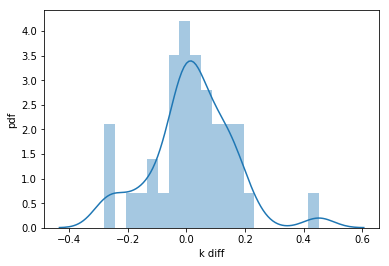

In [58]:
g = sns.distplot(k_values.k_diff, bins=20)
g.axes.set_xlabel('k diff')
g.axes.set_ylabel('pdf')
print(k_values.k_diff.mean())

from scipy.stats import ttest_1samp

ttest_1samp(k_values.k_diff, popmean=0)

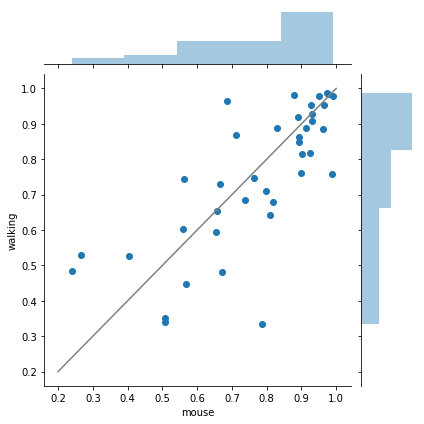

In [60]:
g = sns.jointplot(data=k_values, x='mouse', y='walking')
x = np.linspace(0.2, 1)
g.ax_joint.plot(x, x, color='grey')

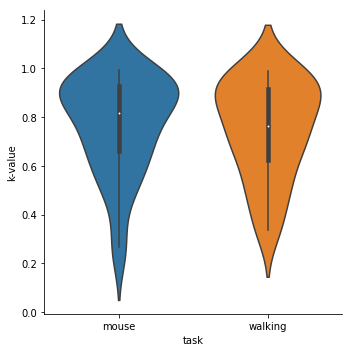

In [57]:
sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index(), 
            x='task', y='k-value', kind='violin')

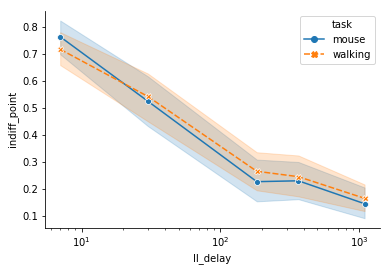

In [63]:
ax = sns.lineplot(data=ip.reset_index(), x='ll_delay', y='indiff_point', hue='task', style='task', markers=True)
sns.despine()
ax.set_xscale('log')

# Task effect might depending on individuals' k?

In [64]:
k_values['k_tertile'] = pd.qcut(k_values.k_mean, 3, labels=[1,2,3]).rename('k_tertile')
k_values_long = pd.melt(k_values, id_vars=['subj_id', 'k_tertile'], 
                        value_vars=['mouse', 'walking'], value_name='k-value')

C:\Users\Arkady\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


It seems that the effect of task might be individual-specific. E.g., people might not universally choose more SS in the walking task, but they might choose their default option more often in that task

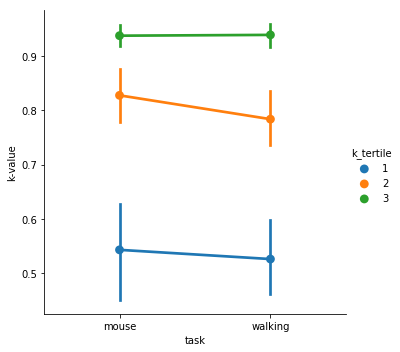

In [65]:
sns.catplot(data=k_values_long, x='task', y='k-value', hue='k_tertile', kind='point')